In [85]:
import pandas as pd
import geopandas as gpd
import folium 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.stats import linregress
import folium
from scipy.stats import pearsonr
import streamlit as st
from streamlit_folium import folium_static
from pysal.lib import weights  
import segregation as seg

In [86]:
# Read zensus data in 100m x 100m grid
df1 = pd.read_csv('../data_example/Zensus_Köln_Buildings.csv', delimiter=';', index_col=0)
df2 = pd.read_csv('../data_example/Zensus_Köln_Families.csv', delimiter=';', index_col=0)
df3 = pd.read_csv('../data_example/Zensus_Köln_Households.csv', delimiter=';', index_col=0)
df4 = pd.read_csv('../data_example/Zensus_Köln_Population.csv', delimiter=';', index_col=0)
df5 = gpd.read_file('../data_example/Zensus_Köln_Grid_100m.gpkg')

In [87]:
# Load the neighborhood polygons
neighborhood_polygons = gpd.read_file('../data_example/BRW_2011_Polygon.shp')

In [58]:
# Load the neighborhood polygons
neighborhood_polygons = gpd.read_file('../data_example/Land_Prices_Neighborhood_Köln.gpkg')

In [59]:

neighborhood_polygons

,Neighborhood_FID,Land_Value,Area_Types,Area_Count,City_Name,geometry
0,1,788.8,CommercialArea_CoreArea_Farmland_GreenArea_Res...,25,Köln,"MULTIPOLYGON (((4113844.607 3091245.039, 41138..."
1,2,874.9,CommercialArea_Farmland_ForestryArea_GreenArea...,32,Köln,"MULTIPOLYGON (((4100028.083 3096909.048, 41000..."
2,3,468.4,CommercialArea_Farmland_ForestryArea_GreenArea...,18,Köln,"MULTIPOLYGON (((4099966.963 3100961.966, 40999..."
3,4,286.0,AgriculturalArea_CommercialArea_Farmland_Green...,25,Köln,"MULTIPOLYGON (((4111198.584 3102570.697, 41112..."
4,5,652.8,Farmland_ForestryArea_Residential_SpecialUseArea,20,Köln,"MULTIPOLYGON (((4112305.385 3102700.016, 41123..."
...,...,...,...,...,...,...
81,82,88.0,AgriculturalArea_CommercialArea_Farmland_Resid...,13,Köln,"MULTIPOLYGON (((4104667.748 3107272.079, 41046..."
82,83,138.3,AgriculturalArea_Farmland_ForestryArea_Residen...,12,Köln,"MULTIPOLYGON (((4102888.748 3108552.142, 41030..."
83,84,35.0,Farmland_Residential,7,Köln,"MULTIPOLYGON (((4115750.422 3086222.340, 41158..."
84,85,435.5,CommercialArea_CoreArea_ForestryArea_GreenArea...,23,Köln,"MULTIPOLYGON (((4109233.260 3095216.098, 41092..."


In [88]:
# Merge them into a single dataframe by the column Grid_Code
merged_df = pd.merge(df1, df2, on='Grid_Code')
merged_df = pd.merge(merged_df, df3, on='Grid_Code')
merged_df = pd.merge(merged_df, df4, on='Grid_Code')
merged_df = pd.merge(merged_df, df5, on='Grid_Code')
zensus_data = gpd.GeoDataFrame(merged_df)
# Extract the grid middle points to match them later to their respective neighborhoods
zensus_data.geometry = zensus_data.geometry.centroid
# Reproject the data to use the same coordinate system
neighborhood_polygons = neighborhood_polygons.to_crs(zensus_data.crs)
# Join the grid points into the neighborhoods and group them
zensus_data_by_neighborhood = gpd.sjoin(zensus_data, neighborhood_polygons, how='left', op='within')
# Drop any non numeric data
zensus_data_by_neighborhood['BRW'] = pd.to_numeric(zensus_data_by_neighborhood.BRW, errors='coerce')
# Drop grid cells with not existing housing values
zensus_data_by_neighborhood = zensus_data_by_neighborhood.dropna(subset=['BRW'])
# Remove geometry column and add polygon areas
zensus_data_by_neighborhood = zensus_data_by_neighborhood.drop(columns=['geometry'])
zensus_data_by_neighborhood = pd.merge(zensus_data_by_neighborhood, neighborhood_polygons[['XWERT', 'geometry']], on='XWERT', how='left')
zensus_data_by_neighborhood_grouped = zensus_data_by_neighborhood.groupby('XWERT')

In [92]:
gpd.GeoDataFrame(zensus_data_by_neighborhood).to_file('cologne_merged_data.gpkg', driver='GPKG')

In [89]:
# Filter all neighborhoods with 100 or less persons
# Get amount of people in neighborhoods
germans_nbgh = zensus_data_by_neighborhood_grouped.sk_germany.sum()
foreign_nbgh = zensus_data_by_neighborhood_grouped.sk_abroad.sum()
amount_of_buildings_nbgh = zensus_data_by_neighborhood_grouped.buildings_total_units.sum()
people_nbgh = (germans_nbgh + foreign_nbgh)/amount_of_buildings_nbgh
# Sort out outliers
filtered_zensus_data = zensus_data_by_neighborhood_grouped.filter(lambda x: (not (germans_nbgh + foreign_nbgh <= 100)[x.name]) and (people_nbgh <= 5)[x.name])
zensus_data_by_neighborhood_grouped = filtered_zensus_data.groupby('XWERT')

In [90]:
zensus_data_by_neighborhood_grouped

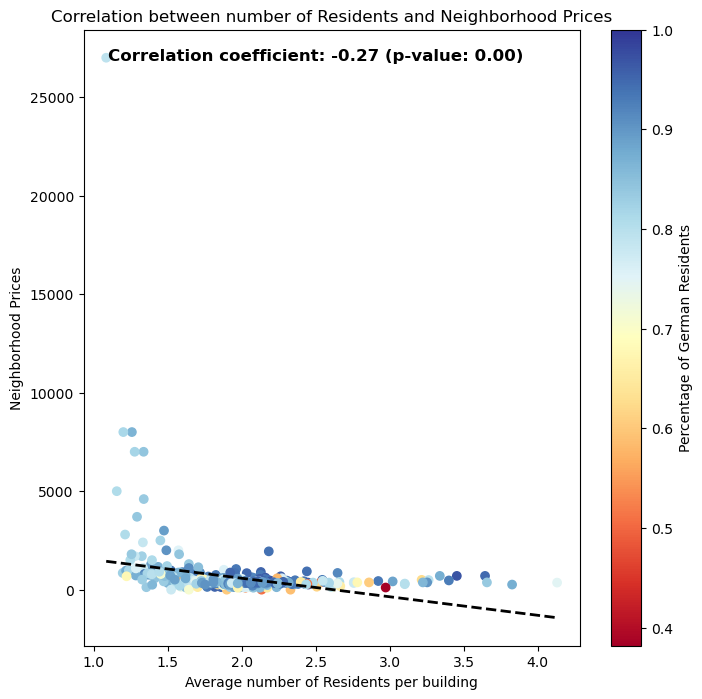

In [67]:
# Example question: How is the distribution of German residents vs. foreign residents in rich vs. poor neighborhoods?
# Get amount of people in neighborhoods
germans_nbgh = zensus_data_by_neighborhood_grouped.sk_germany.sum()
foreign_nbgh = zensus_data_by_neighborhood_grouped.sk_abroad.sum()
# Normalize by amount of buildings in the neighborhood
amount_of_buildings_nbgh = zensus_data_by_neighborhood_grouped.buildings_total_units.sum()
germans_nbgh /= amount_of_buildings_nbgh
foreign_nbgh /= amount_of_buildings_nbgh
people_nbgh = germans_nbgh+foreign_nbgh
# Plot 
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(x=people_nbgh, y=zensus_data_by_neighborhood_grouped.BRW.mean(), c=germans_nbgh/people_nbgh, cmap='RdYlBu', alpha=1)
# Add a color bar
cbar = plt.colorbar(scatter)
cbar.ax.set_ylabel('Percentage of German Residents')
# Add labels and title
ax.set_xlabel('Average number of Residents per building')
ax.set_ylabel('Neighborhood Prices')
ax.set_title('Correlation between number of Residents and Neighborhood Prices')
# Compute the linear regression and plot the line of best fit
slope, intercept, r_value, p_value, std_err = linregress(people_nbgh, zensus_data_by_neighborhood_grouped.BRW.mean())
line_x = np.array([people_nbgh.min(), people_nbgh.max()])
line_y = intercept + slope * line_x
ax.plot(line_x, line_y, color='black', linewidth=2, linestyle='--')

# Add the correlation coefficient to the plot
corr_coef_text = 'Correlation coefficient: {:.2f} (p-value: {:.2f})'.format(r_value, p_value)
ax.text(x=0.05, y=0.95, s=corr_coef_text, transform=ax.transAxes, fontsize=12, fontweight='bold')
plt.show()


In [84]:
import folium

# Create a map centered on Cologne
map = folium.Map(location=[50.938, 6.959], zoom_start=12)
# Group the data by geometry and calculate the mean of the BRW column for each group
zensus_data_by_geometry = gpd.GeoDataFrame(zensus_data_by_neighborhood).dissolve(by='XWERT', aggfunc='sum').reset_index()
# Add the neighborhoods as polygons to the map
folium.Choropleth(
    geo_data=zensus_data_by_geometry,
    name='choropleth',
    data=zensus_data_by_geometry,
    columns=['XWERT', 'BRW'],
    key_on='feature.properties.XWERT',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Land Value'
).add_to(map)

# Add a layer control to toggle the choropleth
folium.LayerControl().add_to(map)

# Display the map in Streamlit
folium_static(map)

2023-04-29 16:52:40.997 
  command:

    streamlit run c:\Users\MorrisKurz\anaconda3\envs\ifohack_spatial_py310\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [77]:
zensus_data_by_geometry.columns

Index(['geometry', 'Grid_Code', 'buildings_total_units', 'n_occupied_by_owner',
       'n_ownership_with_current_household',
       'n_owned_without_current_household',
       'n_rented_for_residential_purposes', 'n_rented_with_current_household',
       'n_rented_without_current_household', 'n_vacation_and_leisure',
       ...
       'UDOK_URL', 'VERF', 'VERG', 'VERGNR', 'WEER', 'WNUM', 'XVERG', 'YVERG',
       'YWERT', 'ZOG'],
      dtype='object', length=240)

In [22]:
# Group the data by geometry and calculate the mean of the BRW column for each group
zensus_data_by_geometry = zensus_data_by_neighborhood.dissolve(by='XWERT', aggfunc='sum')

In [24]:
zensus_data_by_geometry

,geometry,Grid_Code,buildings_total_units,n_occupied_by_owner,n_ownership_with_current_household,n_owned_without_current_household,n_rented_for_residential_purposes,n_rented_with_current_household,n_rented_without_current_household,n_vacation_and_leisure,...,UDOK_URL,VERF,VERG,VERGNR,WEER,WNUM,XVERG,YVERG,YWERT,ZOG
XWERT,,,,,,,,,,,,,,,,,,,,,
5633810,"MULTIPOINT (4114450.000 3084850.000, 4114450.0...",100mN30847E41145100mN30847E41146100mN30847E411...,422,0,221,4,0,177,0,0,...,https://www.boris.nrw.de/borisfachdaten/lgd/br...,0,0,0,0,7130017130017130017130017130017130017130017130...,0,0,3643473643473643473643473643473643473643473643...,0
5634167,"MULTIPOINT (4116350.000 3085950.000, 4116350.0...",100mN30849E41167100mN30849E41168100mN30849E411...,35,0,6,0,0,19,0,0,...,https://www.boris.nrw.de/borisfachdaten/lgd/br...,0,0,0,0,7120027120027120027120027120027120027120027120...,0,0,3664733664733664733664733664733664733664733664...,0
5634349,"MULTIPOINT (4107550.000 3085450.000, 4107550.0...",100mN30854E41075100mN30855E41075100mN30856E410...,0,0,0,0,0,0,0,0,...,https://www.boris.nrw.de/borisfachdaten/lgd/br...,0,0,0,0,2110062110062110062110062110062110062110062110...,0,0,3571203571203571203571203571203571203571203571...,0
5634383,"MULTIPOINT (4109750.000 3085650.000, 4109850.0...",100mN30853E41100100mN30853E41101100mN30853E411...,1164,0,589,12,0,516,10,0,...,https://www.boris.nrw.de/borisfachdaten/lgd/br...,0,0,0,0,7150027150027150027150027150027150027150027150...,0,0,3592733592733592733592733592733592733592733592...,0
5634483,"MULTIPOINT (4105850.000 3086350.000, 4105950.0...",100mN30848E41065100mN30849E41065100mN30849E410...,0,0,0,0,0,0,0,0,...,https://www.boris.nrw.de/borisfachdaten/lgd/br...,0,0,0,0,2120042120042120042120042120042120042120042120...,0,0,3561423561423561423561423561423561423561423561...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659050,"MULTIPOINT (4101550.000 3110250.000, 4101550.0...",100mN31101E41018100mN31101E41019100mN31102E410...,354,0,111,0,0,217,3,0,...,https://www.boris.nrw.de/borisfachdaten/lgd/br...,0,0,0,0,6120056120056120056120056120056120056120056120...,0,0,3507953507953507953507953507953507953507953507...,0
5659093,"MULTIPOINT (4100150.000 3110450.000, 4100150.0...",100mN31098E41004100mN31098E41005100mN31099E410...,2866,0,1011,6,0,1711,32,0,...,https://www.boris.nrw.de/borisfachdaten/lgd/br...,0,0,0,0,6120046120046120046120046120046120046120046120...,0,0,3495053495053495053495053495053495053495053495...,0
5659442,"MULTIPOINT (4100950.000 3110950.000, 4100950.0...",100mN31104E41014100mN31104E41015100mN31105E410...,839,0,411,6,0,370,7,0,...,https://www.boris.nrw.de/borisfachdaten/lgd/br...,0,0,0,0,6120016120016120016120016120016120016120016120...,0,0,3504133504133504133504133504133504133504133504...,0


In [15]:
zensus_data_by_geometry

AttributeError: 'GeoDataFrame' object has no attribute 'XWERT'

In [150]:
zensus_data_by_neighborhood.geometry

35       POINT (4099950.000 3093650.000)
41       POINT (4099850.000 3093750.000)
42       POINT (4099950.000 3093750.000)
48       POINT (4099750.000 3093850.000)
49       POINT (4099850.000 3093850.000)
                      ...               
40501    POINT (4100150.000 3112750.000)
40502    POINT (4100250.000 3112750.000)
40506    POINT (4100050.000 3112850.000)
40507    POINT (4100150.000 3112850.000)
40508    POINT (4100250.000 3112850.000)
Name: geometry, Length: 19935, dtype: geometry

In [137]:
zensus_data_by_neighborhood_grouped.BRW.isnull()

AttributeError: 'SeriesGroupBy' object has no attribute 'isnull'

In [41]:
neighborhood_polygons.BRW

0        170
1        175
2         55
3         45
4         90
        ... 
77650     70
77651      3
77652    2,8
77653      3
77654      1
Name: BRW, Length: 77655, dtype: object

In [40]:
sum(zensus_data_by_neighborhood.BRW.isna())

40512